In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#### Data Loader

In [22]:
## Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, xData, yData, batch_size=16, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.X = xData
        self.Y = yData
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        return self.X[indexes]/255,self.Y[indexes]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

#### Models

In [23]:
def ResnetBlock(in_channels, out_channels, down_sample = False):
    inputs = tf.keras.Input((None, None, in_channels)); # inputs.shape = (batch, height, width, in_channels)
    if down_sample:
        shortcut = tf.keras.layers.Conv2D(out_channels, kernel_size = (1,1), strides = (2,2), padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal())(inputs);
        shortcut = tf.keras.layers.BatchNormalization()(shortcut);
    else:
        shortcut = inputs;
    results = tf.keras.layers.Conv2D(out_channels, kernel_size = (3,3), strides = (2,2) if down_sample else (1,1), padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal())(inputs);
    results = tf.keras.layers.BatchNormalization()(results);
    results = tf.keras.layers.ReLU()(results);
    results = tf.keras.layers.Conv2D(out_channels, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal())(results);
    results = tf.keras.layers.BatchNormalization()(results);
    results = tf.keras.layers.Add()([results, shortcut]);
    results = tf.keras.layers.ReLU()(results);
    return tf.keras.Model(inputs = inputs, outputs = results);

def ResNet18(**kwargs):
    inputs = tf.keras.Input((None, None, 3));
    results = tf.keras.layers.Conv2D(64, kernel_size = (7,7), strides = (2,2), padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal())(inputs);
    results = tf.keras.layers.BatchNormalization()(results);
    results = tf.keras.layers.ReLU()(results);
    results = tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'same')(results);
    results = ResnetBlock(64, 64)(results);
    results = ResnetBlock(64, 64)(results);
    results = ResnetBlock(64, 128, down_sample = True)(results);
    results = ResnetBlock(128, 128)(results);
    results = ResnetBlock(128, 256, down_sample = True)(results);
    results = ResnetBlock(256, 256)(results);
    results = ResnetBlock(256, 512, down_sample = True)(results);
    results = ResnetBlock(512, 512)(results);
    results = tf.keras.layers.GlobalAveragePooling2D()(results); # results.shape = (batch, 512)
    return tf.keras.Model(inputs = inputs, outputs = results, **kwargs);

def Model(baseModel, nClasses):
    inputs = tf.keras.Input((None, None, 3));
    results = baseModel(inputs);
    results = tf.keras.layers.Dense(128,activation = tf.keras.activations.relu)(results);
#     results = tf.keras.layers.Dense(32,activation = tf.keras.activations.relu)(results);
    results = tf.keras.layers.Dense(nClasses, activation = tf.keras.activations.softmax)(results);
    return tf.keras.Model(inputs = inputs, outputs = results);

#### Load the Dataset & Dataloader

In [24]:
(xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.cifar10.load_data()
xSetA, xSetB, ySetA, ySetB = train_test_split(xTrain, yTrain, stratify= yTrain, test_size=0.2)
trainRotDataloader = DataGenerator(xSetA, ySetA, batch_size = 128, shuffle = True)
trainClfDataloader = DataGenerator(xSetB, ySetB, batch_size = 512, shuffle = True)
testClfDataloader  = DataGenerator(xTest, yTest, batch_size = 500, shuffle = False)

#### Load Rotational Models

In [25]:
baseResNetModel = ResNet18()
RotationModel = Model(baseResNetModel, nClasses = 4)
optimizer = tf.keras.optimizers.SGD()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
Acc = tf.keras.metrics.CategoricalAccuracy()

#### Rotation of Images

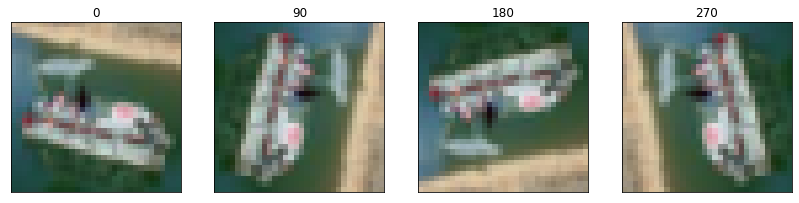

In [26]:
## Get One batch
for _,data in enumerate(trainRotDataloader):
    break
    
index = 89
plt.figure(figsize=(14,4))
plt.subplot(141)
plt.imshow(data[0][index])
plt.title("0"); plt.xticks([]); plt.yticks([]);
plt.subplot(142)
plt.imshow(np.flip(np.transpose(data[0],(0,2,1,3)),axis = 2)[index])
plt.title("90"); plt.xticks([]); plt.yticks([]);
plt.subplot(143)
plt.imshow(np.flip(data[0],axis= 1)[index])
plt.title("180");plt.xticks([]); plt.yticks([]);
plt.subplot(144)
plt.imshow(np.transpose(data[0],(0,2,1,3))[index])
plt.title("270");plt.xticks([]); plt.yticks([]);
plt.show()

In [27]:
epochs = 50
for epoch in range(epochs):
    print("\nepoch {}/{}".format(epoch+1,epochs))
    Acc.reset_states()
    pb = tf.keras.utils.Progbar(len(trainRotDataloader),stateful_metrics=["Loss","Accuracy"])
    for batch,data in enumerate(trainRotDataloader):
        imgs, _ = data
        size = imgs.shape[0]
        
        ## Generate Rotated Images and stack them
        transformedImgs = np.vstack([imgs,np.flip(np.transpose(imgs,(0,2,1,3)),axis = 2),
                              np.flip(imgs,axis= 1),np.transpose(imgs,(0,2,1,3))])
        
        ## Generate one-hot labels for rotation
        labels = np.zeros((size*4,4))
        for i in range(4):
            labels[(i*size):((i+1)*size),i] = 1
            
        ##Forward pass the model
        with tf.GradientTape() as tape:
            pred = RotationModel(transformedImgs)
            loss = loss_fn(labels,pred)
            Acc.update_state(labels,pred)
           
        grads = tape.gradient(loss, RotationModel.trainable_weights)
        optimizer.apply_gradients(zip(grads,RotationModel.trainable_weights))
        pb.update(batch,values=[("Loss",round(loss.numpy(),3)),("Accuracy",Acc.result().numpy())])        


epoch 1/50
311/312 [============================>.] - ETA: 0s - Loss: 1.1410 - Accuracy: 0.4155
epoch 2/50
311/312 [============================>.] - ETA: 0s - Loss: 1.0290 - Accuracy: 0.5188
epoch 3/50
311/312 [============================>.] - ETA: 0s - Loss: 0.9810 - Accuracy: 0.5528
epoch 4/50
311/312 [============================>.] - ETA: 0s - Loss: 0.9470 - Accuracy: 0.5707
epoch 5/50
311/312 [============================>.] - ETA: 0s - Loss: 0.9190 - Accuracy: 0.5828
epoch 6/50
311/312 [============================>.] - ETA: 0s - Loss: 0.9270 - Accuracy: 0.5929
epoch 7/50
311/312 [============================>.] - ETA: 0s - Loss: 0.8780 - Accuracy: 0.6010
epoch 8/50
311/312 [============================>.] - ETA: 0s - Loss: 0.8600 - Accuracy: 0.6104
epoch 9/50
311/312 [============================>.] - ETA: 0s - Loss: 0.8580 - Accuracy: 0.6172
epoch 10/50
311/312 [============================>.] - ETA: 0s - Loss: 0.8360 - Accuracy: 0.6237
epoch 11/50
311/312 [=================

In [ ]:
baseResNetModel.save("baseResNetModel.h5")
RotationModel.save("RotationModel.h5")

#### Train Classifier Model

In [28]:
baseResNetModel.trainable = False
ClassifierModel = Model(baseResNetModel, nClasses = 10)
ClassifierModel.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
model_20 (Functional)        (None, 512)               11190912  
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 11,257,866
Trainable params: 66,954
Non-trainable params: 11,190,912
_________________________________________________________________


In [29]:
epochs = 100
for epoch in range(epochs):
    print("\nepoch {}/{}".format(epoch+1,epochs))
    Acc.reset_states()
    pb = tf.keras.utils.Progbar(len(trainClfDataloader),stateful_metrics=["Loss","Accuracy"])
    for batch,data in enumerate(trainClfDataloader):
        imgs, labels = data
        labels = tf.keras.utils.to_categorical(labels,num_classes=10)
        
        ##Forward pass the model
        with tf.GradientTape() as tape:
            pred = ClassifierModel(imgs)
            loss = loss_fn(labels,pred)
            Acc.update_state(labels,pred)
           
        grads = tape.gradient(loss, ClassifierModel.trainable_weights)
        optimizer.apply_gradients(zip(grads,ClassifierModel.trainable_weights))
        pb.update(batch,values=[("Loss",round(loss.numpy(),3)),("Accuracy",Acc.result().numpy())])


epoch 1/100
18/19 [===========================>..] - ETA: 0s - Loss: 2.2760 - Accuracy: 0.1378
epoch 2/100
18/19 [===========================>..] - ETA: 0s - Loss: 2.2110 - Accuracy: 0.1728
epoch 3/100
18/19 [===========================>..] - ETA: 0s - Loss: 2.1600 - Accuracy: 0.1992
epoch 4/100
18/19 [===========================>..] - ETA: 0s - Loss: 2.1160 - Accuracy: 0.2282
epoch 5/100
18/19 [===========================>..] - ETA: 0s - Loss: 2.0790 - Accuracy: 0.2499
epoch 6/100
18/19 [===========================>..] - ETA: 0s - Loss: 2.0460 - Accuracy: 0.2696
epoch 7/100
18/19 [===========================>..] - ETA: 0s - Loss: 2.0160 - Accuracy: 0.2855
epoch 8/100
18/19 [===========================>..] - ETA: 0s - Loss: 1.9900 - Accuracy: 0.2986
epoch 9/100
18/19 [===========================>..] - ETA: 0s - Loss: 1.9660 - Accuracy: 0.3097
epoch 10/100
18/19 [===========================>..] - ETA: 0s - Loss: 1.9440 - Accuracy: 0.3188
epoch 11/100
18/19 [===========================>

In [ ]:
ClassifierModel.save("ClassifierModel.h5")

In [31]:
### Checking classifier accuracy on cifar 10 test dataset
Acc.reset_states()
for batch,data in enumerate(testClfDataloader):
    imgs, labels = data
    labels = tf.keras.utils.to_categorical(labels)
    
    ##Forward pass the model
    with tf.GradientTape() as tape:
        pred = ClassifierModel(imgs,training=False)
        Acc.update_state(labels,pred)
print("Classifier Accuracy on cifar 10 test dataset",Acc.result().numpy())

Classifier Accuracy on cifar 10 test dataset 0.4391


In [32]:
### Checking rotational accuracy on classifier test dataset
Acc.reset_states()
for batch,data in enumerate(testClfDataloader):
    imgs, labels = data
    size = imgs.shape[0]

    ## Generate Rotated Images and stack them
    transformedImgs = np.vstack([imgs,np.flip(np.transpose(imgs,(0,2,1,3)),axis = 2),
                          np.flip(imgs,axis= 1),np.transpose(imgs,(0,2,1,3))])

    ## Generate one-hot labels for rotation
    labels = np.zeros((size*4,4))
    for i in range(4):
        labels[(i*size):((i+1)*size),i] = 1
        
    ##Forward pass the model
    with tf.GradientTape() as tape:
        pred = RotationModel(transformedImgs,training=False)
        Acc.update_state(labels,pred)
print("Rototional Accuracy on cifar 10 test set",Acc.result().numpy())

Rototional Accuracy on cifar 10 test set 0.6663
